In [173]:
import DataHub as hub
h=hub.Handle.create('Barra')

In [174]:
# Import numpy and pandas 
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import calendar

# If the observations are in a dataframe, you can use statsmodels.formulas.api to do the regression instead
from statsmodels import regression

from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
from sklearn.metrics import r2_score

# allow plots to appear directly in the notebook
%matplotlib inline

In [175]:
name_list=['BetaExp', 'DividendYieldExp',
       'EarningsQualityExp', 'EarningsYieldExp', 'GrowthExp', 'LeverageExp',
       'LiquidityExp', 'LongTermReversalExp', 'ManagementQualityExp',
       'MidCapitalizationExp', 'MomentumExp', 'ProfitabilityExp',
       'ProspectExp', 'SizeExp', 'ValueExp', 'ResidualVolatilityExp',
       'AirlinesExp', 'AluminumSteelExp', 'ApparelandTextilesExp',
       'AutomobilesandComponentsExp', 'BanksExp', 'BeveragesTobaccoExp',
       'BiotechnologyLifeSciencesExp', 'BuildingProductsExp', 'ChemicalsExp',
       'CommercialandProfessionalServicesExp', 'CommunicationsEquipmentExp',
       'ComputersElectronicsExp', 'ConstructionMaterialsExp',
       'ConstructionandEngineeringExp', 'ConstructionandFarmMachineryExp',
       'ContainersandPackagingExp', 'DistributorsMultilineRetailExp',
       'DiversifiedFinancialsExp', 'DiversifiedTelecommunicationServicesExp',
       'ElectricUtilitiesExp', 'ElectricalEquipmentExp', 'FoodProductsExp',
       'FoodandStaplesRetailingExp', 'GasUtilitiesExp',
       'HealthCareEquipmentandTechnologyExp', 'HealthCareProvidersExp',
       'HomebuildingExp', 'HotelsLeisureandConsumerServicesExp',
       'HouseholdDurablesExp', 'HouseholdandPersonalProductsExp',
       'IndustrialConglomeratesExp', 'IndustrialMachineryExp',
       'InsuranceBrokersandReinsuranceExp', 'InternetSoftwareandITServicesExp',
       'InternetandCatalogRetailExp',
       'LeisureProductsTextilesApparelandLuxuryExp',
       'LifeHealthandMultilineInsuranceExp', 'ManagedHealthCareExp',
       'MediaExp', 'MultiUtilitiesWaterUtilitiesPowerExp',
       'OilGasandConsumableFuelsExp', 'OilandGasDrillingExp',
       'OilandGasEquipmentandServicesExp',
       'OilandGasExplorationandProductionExp', 'PaperandForestProductsExp',
       'PharmaceuticalsExp', 'PreciousMetalsGoldMiningExp', 'RealEstateExp',
       'RestaurantsExp', 'RoadandRailExp', 'SemiconductorEquipmentExp',
       'SemiconductorsExp', 'SoftwareExp', 'SpecialtyChemicalsExp',
       'SpecialtyRetailExp', 'SpecialtyStoresExp',
       'TradingCompaniesandDistributorsExp',
       'TransportationAirFreightandMarineExp',
       'WirelessTelecommunicationServicesExp','CountryExp']

In [176]:
start_date='20180101'
end_date='20181231'

loadings = h.read('DailyFactor', start=start_date, end=end_date)
loadings['CountryExp']=1
loadings['ReturnPct']=loadings['ReturnPct']*0.01
loadings=loadings.set_index(['date', 'ticker']).sort_index()
# draw out the timestamp for every month
M=loadings.index.get_level_values(0)
Timestamp = []
for i in M:
    if not i in Timestamp:
        Timestamp.append(i)

In [177]:
residual = [[] for _ in range(len(Timestamp))]
for i in range(len(Timestamp)):
    Xi = pd.DataFrame()
    # For each month, we load 'retun_shift' 
    Yi = np.array((loadings.loc[(Timestamp[i],slice(None)),'ReturnPct']).reset_index(drop=True))
    for j in range(len(name_list)):                        
        # For each month, we load all the exposures and store them as a dataframe. The columns of the dataframe are the regressors we will use.
        Xij = np.array((loadings.loc[(Timestamp[i],slice(None)),name_list[j]]).reset_index(drop=True))
        Xi[j] = Xij

    # linear regression
    linreg.fit(Xi, Yi)
    residuali = list(Yi - linreg.predict(Xi))
    residual[i].append(residuali)
    # residual[i][0] list of residuals on day i

In [186]:
residual_AAPL=[]
residual_BAC=[]
residual_INTC=[]
for i in range(len(Timestamp)):
    datai=loadings.loc[(Timestamp[i],slice(None)),:]
    # find the asset position in time-split dataframe
    AAPL_posi = list(datai.index.get_level_values(1)).index('AAPL')
    BAC_posi = list(datai.index.get_level_values(1)).index('BAC')
    INTC_posi = list(datai.index.get_level_values(1)).index('INTC')
    # draw the residual of specific asset according to the asset position derived above
    residual_AAPL.append(residual[i][0][AAPL_posi])
    residual_BAC.append(residual[i][0][BAC_posi])
    residual_INTC.append(residual[i][0][INTC_posi])
    

In [187]:
specific_for_three = pd.DataFrame({"date":Timestamp, "residual_AAPL" : residual_AAPL,'residual_BAC':residual_BAC,'residual_INTC':residual_INTC})




In [197]:
my_df = pd.read_csv('specific_return.csv')

In [202]:
from scipy.stats import pearsonr
# two outputs: pearson correlation and p-value
pearsonr(specific_for_three['residual_AAPL'],my_df['APPLE INC (USAB1X1)'])

(0.9797500368886497, 6.166291461674346e-176)

In [203]:
pearsonr(specific_for_three['residual_BAC'],my_df['BANK OF AMERICA CORPORATION (USAJIJ1)'])

(0.956745943333961, 1.5989250718336852e-135)

In [204]:
pearsonr(specific_for_three['residual_INTC'],my_df['INTEL CORP (USAH8Z1)'])

(0.9689460387568614, 4.146382021549611e-153)

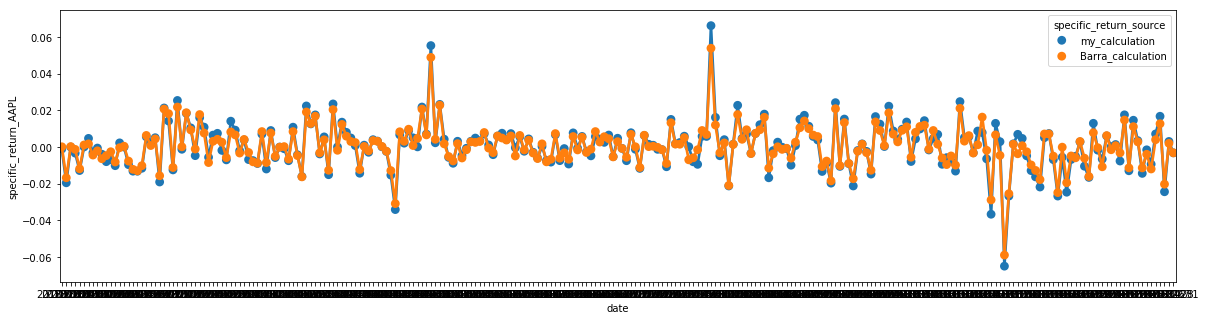

In [208]:
import matplotlib.pyplot as plt

date = Timestamp
df1 = pd.DataFrame({"date":date, "specific_return_AAPL" : np.array(specific_for_three['residual_AAPL'])})
df2 = pd.DataFrame({"date":date, "specific_return_AAPL" : np.array(my_df['APPLE INC (USAB1X1)'])})


df1['specific_return_source'] = 'my_calculation'
df2['specific_return_source'] = 'Barra_calculation' 

df = pd.concat([df1,df2])
x_col='date'
y_col = 'specific_return_AAPL'
fig = plt.figure(figsize=(20,5))
fig.add_subplot(1,1,1)
sns.pointplot(x=x_col,y=y_col,data=df,hue='specific_return_source')

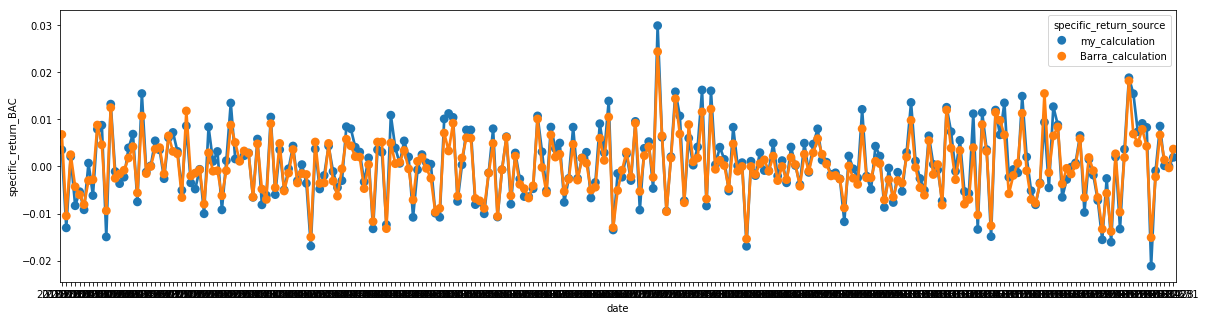

In [209]:
import matplotlib.pyplot as plt

date = Timestamp
df1 = pd.DataFrame({"date":date, "specific_return_BAC" : np.array(specific_for_three['residual_BAC'])})
df2 = pd.DataFrame({"date":date, "specific_return_BAC" : np.array(my_df['BANK OF AMERICA CORPORATION (USAJIJ1)'])})


df1['specific_return_source'] = 'my_calculation'
df2['specific_return_source'] = 'Barra_calculation' 

df = pd.concat([df1,df2])
x_col='date'
y_col = 'specific_return_BAC'
fig = plt.figure(figsize=(20,5))
fig.add_subplot(1,1,1)
sns.pointplot(x=x_col,y=y_col,data=df,hue='specific_return_source')

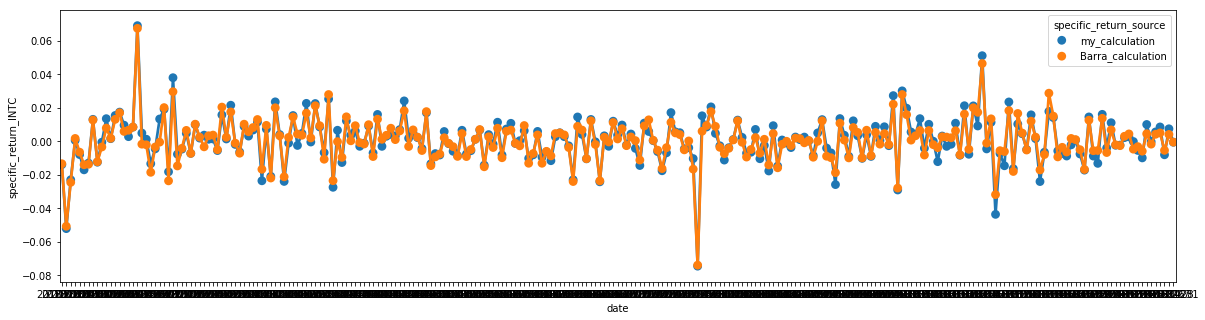

In [210]:
import matplotlib.pyplot as plt

date = Timestamp
df1 = pd.DataFrame({"date":date, "specific_return_INTC" : np.array(specific_for_three['residual_INTC'])})
df2 = pd.DataFrame({"date":date, "specific_return_INTC" : np.array(my_df['INTEL CORP (USAH8Z1)'])})


df1['specific_return_source'] = 'my_calculation'
df2['specific_return_source'] = 'Barra_calculation' 

df = pd.concat([df1,df2])
x_col='date'
y_col = 'specific_return_INTC'
fig = plt.figure(figsize=(20,5))
fig.add_subplot(1,1,1)
sns.pointplot(x=x_col,y=y_col,data=df,hue='specific_return_source')